Forecastimg Gold Price Time Series Exercise 4

In [1]:
# important libraries are installed and imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

Loading the Gold price dataset in pandas

In [2]:
df = pd.read_csv("gold_price_data.csv")

In [3]:
# having observed critically
# in the early year, the pattern 
# is every 3 days in a month
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [4]:
# initially I considered the 
# time span of 20 years (6720)
# before the millenial
# however, I decided to extend 
# it to 3 years prior to 2020
df = df.iloc[0:10080]

In [5]:
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10075,2017-06-22,1250.80
10076,2017-06-23,1255.70
10077,2017-06-26,1245.25
10078,2017-06-27,1249.55


In [6]:
# in this cell the date is dropped and 
# then replace index with 0.1 steps
df = df.drop("Date", axis=1)
df.index = df.index * 0.1 + 1

In [7]:
# then saving the target value column, 
# as this automatically
# split the data without changes
value_column = "Value"

In [8]:
# let's scale the values with MinMaxScaler, so that we don't
# affect the distribution of data (thus making the signal not be realistic anymore)
# The MinMaxScaler is used
# to help scale the values 
# making the distribution of the data 
# evenly when training the model
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])
df.index = df.index * 0.1 + 1

In [9]:
df

,Value
1.10,0.000054
1.11,0.000000
1.12,0.000161
1.13,0.000591
1.14,0.001237
...,...
101.85,0.653637
101.86,0.656272
101.87,0.650653
101.88,0.652965


Now is to figure out the splitting of the training/test
 X_train, y_train, X_test, y_test

In [10]:
# here,cutoff point is used
# for train/test split
# this reveals the trend in the Value
# and the cutoff is split
# training 0.80 and test 0.20
# begins with a smaller test size
cutoff = int(len(df) * 0.80)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert to NumPy -array -format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

# NOTE to self: is this necessary?
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

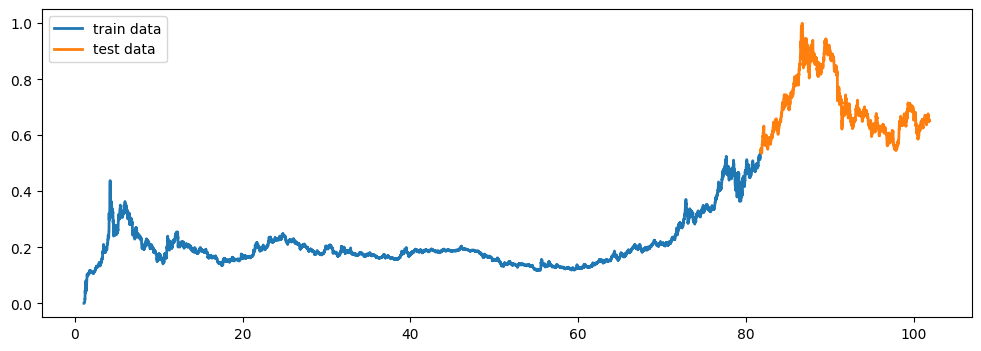

In [11]:
# plot the original train + test data
# and then see the cutoff point
# the train data plot 
# as the y_train increases the X_train does same
# however the pattern changes as y_train drops steadily
# and rises slightly and then dropped along the X_train
# until it began the pattern began to rise again
# and subsequently the test data increses and decreases 
# along the X_test
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(X_train, y_train, lw=2, label='train data')
ax.plot(X_test, y_test,  lw=2, label='test data')
ax.legend(loc="upper left")
plt.show()

In [13]:
# TimeseriesGenerators, for train and test
# for generating training data and testing data
# which deals with sequential data
#  the parameter look_back determines the number of time steps 
# in the past that the model will consider 
# when making predictions. 
# choosing look_back of 20 means that the 
# model will consider the previous 
# 20 time steps to predict the next time step.
# the TimeseriesGenerator seems to be an older version
# so I wrote a prompt in ChatGPT how best to 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from keras.preprocessing.sequence import TimeseriesGenerator

# this is the time step size
# for every 1000 points, I set the  look_back to 20 => 50 time steps
look_back  = 20

# using 1 => using time steps
# anything over 1 => using windowing
window_size = 1

# the amount of data fed to the neural network
# while training. the bigger it is, faster the training
# but with forecasts it also affects the performance
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      # sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      # sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [14]:
from keras.models import Sequential
from keras.layers import Dense

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# depends on the situation which one suits your dataset better
from keras.layers import LSTM
from keras.layers import SimpleRNN

# make a simple LSTM -network
# you can adjust the number of neurons
# you can also try SimpleRNN
model = Sequential()

# you can also chain up multiple LSTM-layers
# remember to use return_sequences when passing from an LSTM-layer
# to another LSTM-layer. NOTE! Never have return_sequences in the last LSTM-layer
# if you want regularization, you can add a Dropout-layer also!
# model.add(LSTM(48, activation="relu", input_shape=(look_back, n_features), return_sequences=True))
# model.add(LSTM(24, activation="relu")),

model.add(LSTM(36, activation="relu", input_shape=(look_back, n_features)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_sales.keras', monitor='val_loss', mode='min', save_best_only=True)

# have all callbacks in a list
# this time we only have one
callback_list = [mc]
# start training the data, use also validation data for metrics later
model.fit(train_generator, epochs=50, verbose=1, validation_data=test_generator, callbacks=callback_list)

c:\Users\Admin\DeepLearningSpringNew2024\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
   7/8044 ━━━━━━━━━━━━━━━━━━━━ 1:10 9ms/step - loss: 0.0655  

c:\Users\Admin\DeepLearningSpringNew2024\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8044/8044 ━━━━━━━━━━━━━━━━━━━━ 70s 8ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 2/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 4.7436e-05 - val_loss: 1.0492e-04
Epoch 3/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 3.2318e-05 - val_loss: 9.1797e-05
Epoch 4/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 72s 9ms/step - loss: 2.7450e-05 - val_loss: 9.7402e-05
Epoch 5/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - loss: 2.4098e-05 - val_loss: 7.2442e-05
Epoch 6/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 2.2547e-05 - val_loss: 9.6441e-05
Epoch 7/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 2.2069e-05 - val_loss: 4.6469e-04
Epoch 8/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step - loss: 2.2439e-05 - val_loss: 9.8493e-05
Epoch 9/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step - loss: 2.2662e-05 - val_loss: 2.2517e-04
Epoch 10/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 2.0000e-05 - val_loss: 1.9266e-04
Epoch 11/50
8044/8044 ━━━━━━━━━━━━━━━━━━━━ 68s 

<Axes: >

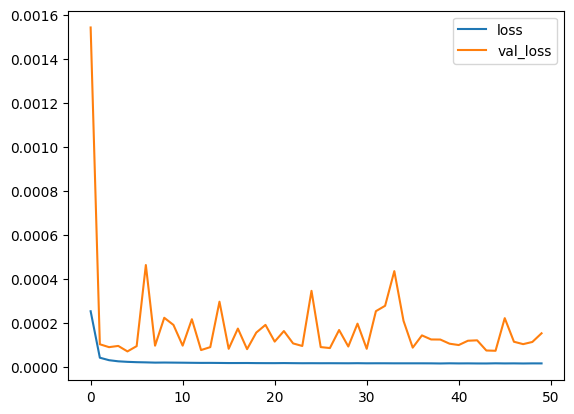

In [15]:
# then the training metrics
# training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [16]:
 
# Loading a pre-trained neural network model from 
# a saved file named 'best_model_sales.keras'.
from keras.models import load_model
model = load_model('best_model_sales.keras')

In [17]:
# Predicting using the trained model on the test generator data.
# The output indicates that predictions have been 
# made for 1996 samples in the test dataset.
# It took approximately 9 seconds to make these predictions, 
# with an average time of 4 milliseconds per step.
test_predictions  = model.predict(test_generator)

1996/1996 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


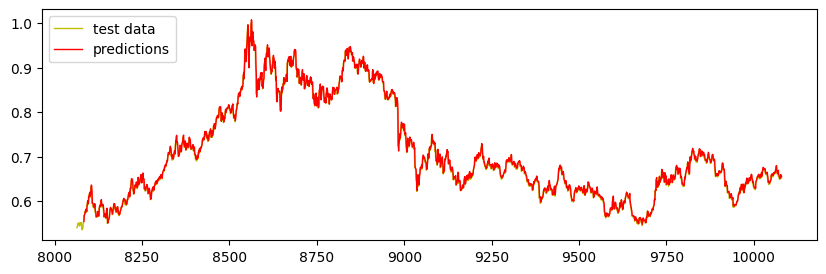

In [18]:
# Generating x-coordinates for the plot:
# x1 represents the indices for the training data.
# x2 represents the indices for the test data, 
# starting after the last index of the training data.
# x3 represents the indices for the forecasted data, 
# starting after a look-back period from the test data.
# and shows the model will do so well in predictions
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the training data to inspect the
# the predictions vs. test data separately
# ax.plot(x1, y_train, lw=1, label='train data')
ax.plot(x2, y_test, lw=1, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()

In [19]:
# TF evaluation metrics
# probably the model needs 
# to be optimized 
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

8044/8044 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 2.4047e-05
Training loss: 1.5217393411148805e-05
1996/1996 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.9719e-05
Testing loss: 7.244238804560155e-05


Overall, the outputs collectively indicate that the model has performed exceptionally well in predicting the target variable, demonstrating high accuracy, minimal error, and a strong fit to the data.

In [20]:
# make a separate copy of the test values
# that matches with y_test
# the MAPE of 0.84% indicates a very low average error rate,
# indicating excellent predictive performance.
# the MAE value of 0.01 units means, on average, 
# the model's predictions are off by 0.01 units from the actual values.
# the MSE value of 0.0 units^2 suggests very minimal error in prediction, practically perfect.
# the RMSE  value of 0.01 units indicates low average error magnitude, 
# consistent with the low MAE and MSE.
# value of 0.99 signifies that 99% of the variance
# in the dependent variable is predictable 
# from the independent variables, suggesting 
# an excellent fit of the model to the data.
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# the typical error metrics
# MAE - Mean average error
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20 % => good result
# MAPE score => 20-50% => okay / reasonable / decent result
# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values
# it's possible to get a weird MAPE result with synthetic test data
# because the data is so predicatble
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test , test_predictions), 2), " units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), " units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test , test_predictions)), 2), " units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test , test_predictions), 2))

MAPE (mean average precision error):
0.84 %

MAE
0.01  units

MSE
0.0  units^2

RMSE:
0.01  units

R-squared:
0.99


In [23]:
# EXTRAPOLATION TEST
# chosen 180
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(360):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

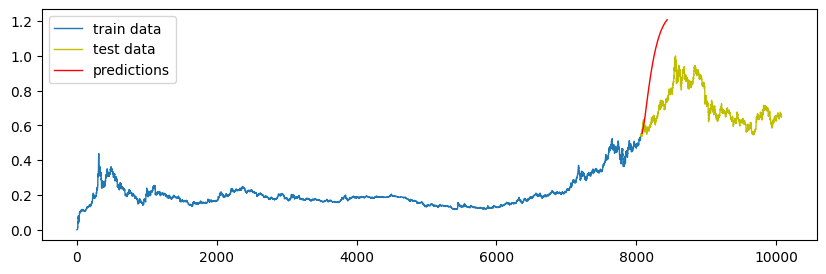

In [24]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the training data to inspect the
# the predictions vs. test data separately
ax.plot(x1, y_train, lw=1, label='train data')
ax.plot(x2, y_test, lw=1, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()